In [1]:
%%time
import sys
import torch
import numpy as np
sys.path.append('../')
from env import QuantumControl
env_params = {'max_stamp': 7, 'batch_size': 1}

qc = QuantumControl(**env_params)
baseline = np.array([[-0.0018216546513159368, 0.0021649111307008267], 
                      [0.00295401791696428, -0.0004872600190229271], 
                      [-4.7152522857042517e-07, 0.0006462490557820025], 
                      [-0.001929144421123893, 0.002999860191281257]]).astype('float64')
first_action = torch.from_numpy(baseline[0])
first_action.requires_grad = True
qc.step(first_action)
fidelities = []
for action in baseline[1:]:
    qc.step(torch.from_numpy(action))
    fidelities.append(qc.fidelity.item())
for action in np.zeros((5,2)):
    qc.step(torch.from_numpy(action))
    fidelities.append(qc.fidelity.item())
qc.fidelity

CPU times: user 4min 21s, sys: 12.6 s, total: 4min 34s
Wall time: 4min 30s


tensor([0.9780], dtype=torch.float64, grad_fn=<SumBackward1>)

In [2]:
fidelities

[0.08731056307986021,
 0.6113357062149698,
 0.05455272513882464,
 0.12987076826375385,
 0.8965350852445368,
 0.9858542645250471,
 0.9773148872953948,
 0.9779745625384781]

In [4]:
loss = ((qc.qubit_target - qc.qubit_state[:,:,:,0])**2).sum()
# loss = qc.qubit_resonator_state.mean()
loss

tensor(0.0346, dtype=torch.float64, grad_fn=<SumBackward0>)

In [5]:
loss.backward()

In [6]:
first_action.grad

tensor([  67.0645, -308.3094], dtype=torch.float64)

In [9]:
lr=1e-5

In [7]:
first_action

tensor([-0.0018,  0.0022], dtype=torch.float64, requires_grad=True)

In [4]:
%%time
import sys
import torch
import numpy as np
sys.path.append('../')
from env import QuantumControl
import tensorflow as tf
tf.enable_eager_execution()
env_params = {'max_stamp': 7, 'batch_size': 1}

qc = QuantumControl(**env_params)
baseline = np.array([[-0.0018216546513159368, 0.0021649111307008267], 
                      [0.00295401791696428, -0.0004872600190229271], 
                      [-4.7152522857042517e-07, 0.0006462490557820025], 
                      [-0.001929144421123893, 0.002999860191281257]]).astype('float64')
for action in baseline:
    qc.step(np.array([action]))
for action in np.zeros((5,2)):
    qc.step(np.array([action]))
qc.fidelity

/mnt/aryzhikov/envs/tf/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:867: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/mnt/aryzhikov/envs/tf/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:867: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


CPU times: user 4min 23s, sys: 292 ms, total: 4min 24s
Wall time: 4min 21s


<tf.Tensor: id=6617055, shape=(1,), dtype=float32, numpy=array([0.9779825], dtype=float32)>

In [12]:
import sys
import os
import shutil
import glob
from tqdm import trange
import numpy as np

sys.path.append('../tf_env/')
sys.path.append('../')

from env import QuantumControl
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

max_steps = 4
zero_steps = 3
amp = 1e-2
grad_clip=1e2
env_params = {'max_stamp': 7, 'batch_size': 1}

qc = QuantumControl(**env_params)
env_params['inverse'] = True
qc_inv = QuantumControl(**env_params)
zero_control = tf.constant([0.0, 0.0])

baseline = np.array([[-0.0018216546513159368, 0.0021649111307008267], 
                      [0.00295401791696428, -0.0004872600190229271], 
                      [-4.7152522857042517e-07, 0.0006462490557820025], 
                      [-0.001929144421123893, 0.002999860191281257]]).astype('float64')

def reset():
    obs = qc.reset()
    obs_inv = qc_inv.reset()
    obs = tf.concat([obs, obs_inv], 1)
    return obs

def step(action):
    action = tf.expand_dims(action, 0)
    action = tf.dtypes.cast(action, dtype=tf.float64)
    action=amp*tf.tanh(action)
    obs, _, episode_over, _ = qc.step(action)
    obs_inv, _, _, _ = qc_inv.step(action)
    obs = tf.concat([obs, obs_inv], 1)
    return obs, episode_over

def eval_loss(env):
    diff = (env.qubit_state - env.qubit_target)
    diff = tf.math.real(diff * tf.math.conj(diff))
    diff = tf.math.reduce_sum(diff, axis=[1,2])
    return tf.math.reduce_mean(diff)


/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:867: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())

/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:867: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())

/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:867: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:867: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


In [2]:
reset()
actions = np.load('../models/checkpoints/best_traj_lbfgs_long.npz')['arr_0']; print(actions)
for action in actions:
    step(action)
    print(0.5*(qc.fidelity + qc_inv.fidelity))
for _ in range(8):
    step(zero_control)
    print(0.5*(qc.fidelity + qc_inv.fidelity))

[[-1.02592344  1.78029094]
 [ 0.28506942  0.1422563 ]
 [ 0.00439997  0.00712992]
 [-0.35520579  0.31749861]
 [-0.50644397  0.21609204]
 [-0.51727605  0.13105685]
 [-0.52952763  0.13413587]
 [-0.52168418  0.13129153]]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



tf.Tensor([0.6064839], shape=(1,), dtype=float32)
tf.Tensor([0.11112416], shape=(1,), dtype=float32)
tf.Tensor([0.12428214], shape=(1,), dtype=float32)
tf.Tensor([0.7739513], shape=(1,), dtype=float32)
tf.Tensor([0.52125144], shape=(1,), dtype=float32)
tf.Tensor([0.46084982], shape=(1,), dtype=float32)
tf.Tensor([0.46859622], shape=(1,), dtype=float32)
tf.Tensor([0.47489974], shape=(1,), dtype=float32)
tf.Tensor([0.50219935], shape=(1,), dtype=float32)
tf.Tensor([0.612617], shape=(1,), dtype=float32)
tf.Tensor([0.6265265], shape=(1,), dtype=float32)
tf.Tensor([0.641681], shape=(1,), dtype=float32)
tf.Tensor([0.64383256], shape=(1,), dtype=float32)
tf.Tensor([0.6415281], shape=(1,), dtype=float32)
tf.Tensor([0.6458347], shape=(1,), dtype=float32)
tf.Tensor([0.6408305], shape=(1,), dtype=float32)


In [3]:
for _ in range(4):
    step(zero_control)
    print(0.5*(qc.fidelity + qc_inv.fidelity))

tf.Tensor([0.71650445], shape=(1,), dtype=float32)
tf.Tensor([0.7178595], shape=(1,), dtype=float32)
tf.Tensor([0.7131518], shape=(1,), dtype=float32)
tf.Tensor([0.71526575], shape=(1,), dtype=float32)


In [16]:
# # actions = np.load('../models/checkpoints/best_traj_lbfgs.npz')['arr_0']
actions = np.array([[-0.0018216546513159368, 0.0021649111307008267], 
                      [0.00295401791696428, -0.0004872600190229271], 
                      [-4.7152522857042517e-07, 0.0006462490557820025], 
                      [-0.001929144421123893, 0.002999860191281257]]).astype('float64')
actions = tf.atanh(actions/amp)

for action in actions:
    step(action)
    print(0.5*(qc.fidelity + qc_inv.fidelity))
for _ in range(2):
    step(zero_control)
    print(0.5*(qc.fidelity + qc_inv.fidelity))

tf.Tensor([0.22078931], shape=(1,), dtype=float32)
tf.Tensor([0.10459945], shape=(1,), dtype=float32)
tf.Tensor([0.5085738], shape=(1,), dtype=float32)
tf.Tensor([0.21848272], shape=(1,), dtype=float32)
tf.Tensor([0.4338673], shape=(1,), dtype=float32)
tf.Tensor([0.91536164], shape=(1,), dtype=float32)


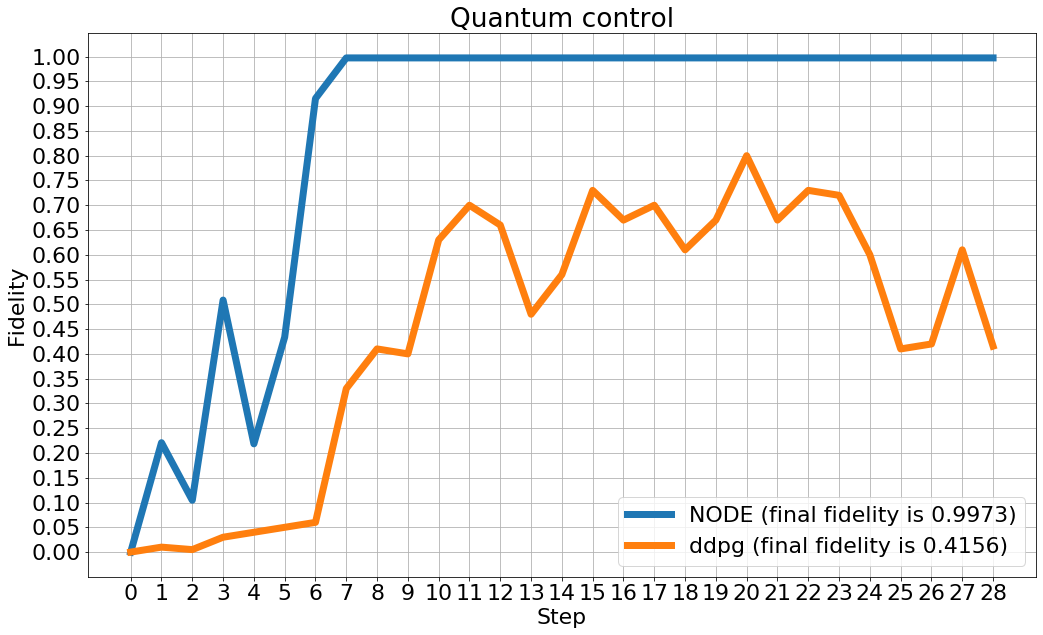

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
fidelities = [0, 0.22078931, 0.10459945, 0.5085738, 0.21848272, 0.4338673, 0.91536164, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973, 0.9973,0.9973]
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(17,10))

plt.title(f'Quantum control')
plt.ylabel('Fidelity')
plt.xlabel('Step')
plt.grid()
plt.xticks(range(29))
plt.yticks([0.05*i for i in range(21)])
plt.plot(fidelities, label=f'NODE (final fidelity is {fidelities[-1]})', linewidth=7)
ddpg_fid = [0,0.01,0.005,0.03, 0.04, 0.05, 0.06, 0.33, 0.41, 0.4, 0.63, 0.7, 0.66, 0.48, 0.56, 0.73, 0.67, 0.7, 0.61, 0.67, 0.8, 0.67, 0.73, 0.72, 0.6, 0.41, 0.42, 0.61, 0.4156]
plt.plot(ddpg_fid, label=f'ddpg (final fidelity is {ddpg_fid[-1]})', linewidth=7)
plt.legend()

In [ ]:
best_steps = []

for step_n in trange(max_steps):
    def opt_function(control):
        reset()
        for prev_action in best_steps:
            step(prev_action)
        with tf.GradientTape() as t:
            t.watch(control)
            step(control)
            for _ in range(zero_steps):
                step(zero_control)
            loss, loss_inv = eval_loss(qc), eval_loss(qc_inv)
            loss_total = 0.5*(loss + loss_inv)
            loss_total = tf.dtypes.cast(loss_total, dtype=tf.float64)
        l, g = loss_total, t.gradient(loss_total, control)
        print((l,g))
        return l, g
    
    if step_n < len(baseline): start_control = baseline[step_n]
    else: start_control = tf.constant(0.01*np.random.randn(2,))
    optim_results = tfp.optimizer.lbfgs_minimize(
        opt_function, initial_position=start_control, tolerance=1e-7, max_iterations=30)
    best_step = tf.stop_gradient(optim_results.position)
    best_steps.append(best_step)


  0%|          | 0/4 [00:00<?, ?it/s]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
tfp.math.BD